In [ ]:
!pip install roboflow

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from roboflow import Roboflow
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import os

# --- DOWNLOAD DATA ---
rf = Roboflow(api_key="HfQb90ewlbT7Lx96FkPm")
project = rf.workspace("pranoy-sarath-bxhrk").project("processed-rock-paper")
version = project.version(2)
dataset = version.download("folder")

print(f"Dataset downloaded to: {dataset.location}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 86.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 84.6 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Processed-Rock-Paper-2 in folder:: 100%|██████████| 2939/2939 [00:00<00:00, 13483.31it/s]

Dataset downloaded to: /content/Processed-Rock-Paper-2


In [ ]:
# --- CONFIGURATION ---
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on: {DEVICE}")

# --- TRANSFORMS ---
# Resize and Normalize images so they match what the models expect
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# --- LOADERS ---
# Training Data
train_set = datasets.ImageFolder(root=f'{dataset.location}/train', transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

# Test Data (Safety Check: uses 'valid' folder if 'test' is empty)
test_dir = f'{dataset.location}/test'
if not os.path.exists(test_dir) or len(os.listdir(test_dir)) == 0:
    print("Test folder missing or empty. Using 'valid' folder for testing.")
    test_dir = f'{dataset.location}/valid'

test_set = datasets.ImageFolder(root=test_dir, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

print(f"Classes found: {train_set.classes}")

Training on: cuda
Classes found: ['paper', 'rock', 'scissors']


In [ ]:
class EnsembleModel(nn.Module):
    def __init__(self, num_classes=3): # 3 Classes: Rock, Paper, Scissors
        super(EnsembleModel, self).__init__()

        # Brain 1: ResNet50 (Remove last layer)
        resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.resnet_features = nn.Sequential(*list(resnet.children())[:-1])

        # Brain 2: EfficientNet B0 (Remove last layer)
        effnet = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
        self.effnet_features = nn.Sequential(*list(effnet.children())[:-1])

        # The Merger (Classifier)
        # ResNet outputs 2048 features, EfficientNet outputs 1280
        # Total input to classifier = 2048 + 1280 = 3328
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2048 + 1280, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # Get features from both models
        r_out = self.resnet_features(x)
        e_out = self.effnet_features(x)

        # Flatten and Concatenate
        r_out = r_out.view(r_out.size(0), -1)
        e_out = e_out.view(e_out.size(0), -1)
        merged = torch.cat((r_out, e_out), dim=1)

        # Classify
        return self.classifier(merged)

# Initialize Model and send to GPU/CPU
model = EnsembleModel(num_classes=3).to(DEVICE)
print("Ensemble Model Created Successfully.")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 74.4MB/s]


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 53.1MB/s]


Ensemble Model Created Successfully.


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Starting Training...")
EPOCHS = 5

for epoch in range(EPOCHS):
    model.train() # Set mode to training
    running_loss = 0.0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{EPOCHS} finished. Average Loss: {avg_loss:.4f}")

# Save the trained model
torch.save(model.state_dict(), "rps_ensemble.pth")
print("Training Complete! Model saved as 'rps_ensemble.pth'")

Starting Training...
Epoch 1/5 finished. Average Loss: 0.1410
Epoch 2/5 finished. Average Loss: 0.0022
Epoch 3/5 finished. Average Loss: 0.0001
Epoch 4/5 finished. Average Loss: 0.0504
Epoch 5/5 finished. Average Loss: 0.0707
Training Complete! Model saved as 'rps_ensemble.pth'


In [ ]:
correct = 0
total = 0
model.eval() # Set mode to evaluation (turns off dropout)

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Final Accuracy on Test Set: {100 * correct / total:.2f}%')

Final Accuracy on Test Set: 98.77%


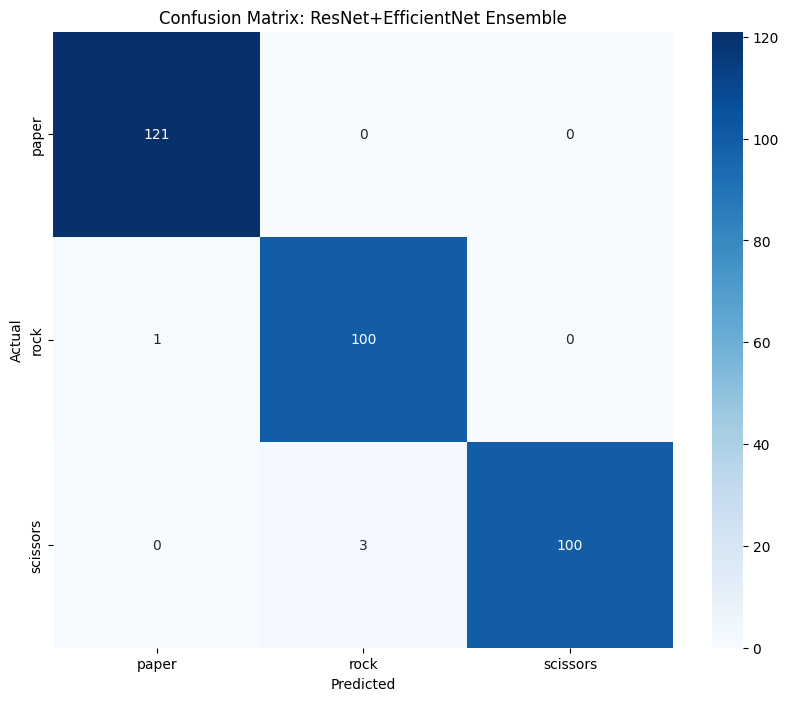

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Get all predictions
y_pred = []
y_true = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(DEVICE)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# 2. Generate Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
class_names = train_set.classes

# 3. Plot it nicely
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix: ResNet+EfficientNet Ensemble')
plt.show()

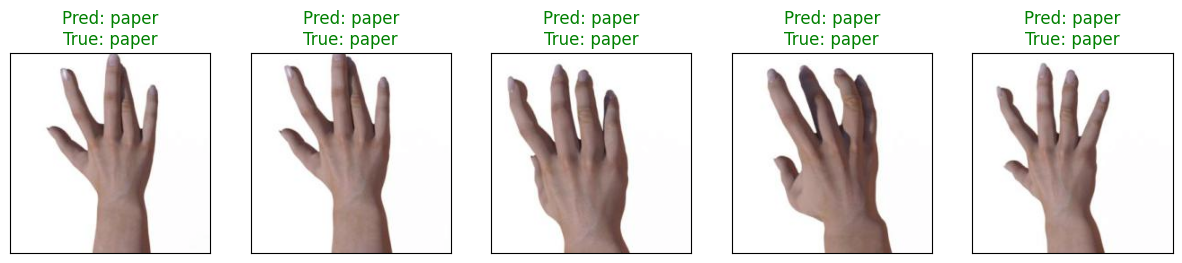

In [ ]:
def imshow(img):
    # Un-normalize for display
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Get a batch of test data
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(DEVICE), labels.to(DEVICE)

# Predict
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Plot the first 5 images
fig = plt.figure(figsize=(15, 6))
for idx in range(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    # Move back to CPU for plotting
    img_cpu = images[idx].cpu()

    # Inverse normalize (approximate) to make image visible
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img_cpu = img_cpu * std + mean

    plt.imshow(img_cpu.permute(1, 2, 0).numpy())

    # Label formatting
    pred_label = train_set.classes[predicted[idx]]
    true_label = train_set.classes[labels[idx]]
    color = 'green' if pred_label == true_label else 'red'

    ax.set_title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)

plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Use the y_true and y_pred lists we created in the previous step
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

       paper       0.99      1.00      1.00       121
        rock       0.97      0.99      0.98       101
    scissors       1.00      0.97      0.99       103

    accuracy                           0.99       325
   macro avg       0.99      0.99      0.99       325
weighted avg       0.99      0.99      0.99       325

